In [1]:
!pip install Pillow
!pip install tensorflow

In [2]:
import tensorflow as tf

from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt

import xml.dom.minidom
import os

from PIL import Image
from sklearn.model_selection import train_test_split
import numpy as np

2023-03-16 16:11:02.065080: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
path_suff = "maksssksksss"
n = 853

classes = ['with_mask', 'mask_weared_incorrect', 'without_mask']

def return_code(label):
    return classes.index(label)

imgs = []
labels = []
for i in range(n):
    img = Image.open('./images/{suff}{num}.png'.format(suff=path_suff, num=str(i)))
    
    doc = xml.dom.minidom.parse('./annotations/{suff}{num}.xml'.format(suff=path_suff, num=str(i)))
    names = doc.getElementsByTagName("name")
    xmins = doc.getElementsByTagName("xmin")
    ymins = doc.getElementsByTagName("ymin")
    xmaxs = doc.getElementsByTagName("xmax")
    ymaxs = doc.getElementsByTagName("ymax")
    
    for j in range(len(names)):
        labels.append([return_code(names[j].firstChild.data)])
        temp = img.crop((float(xmins[j].firstChild.data), float(ymins[j].firstChild.data),
                         float(xmaxs[j].firstChild.data), float(ymaxs[j].firstChild.data))).convert('RGB')
        
        temp = tf.image.convert_image_dtype(temp, tf.float32)
        
        imgs.append(np.asarray(tf.image.resize(temp, (32, 32))))

print("Number of Images: " + str(len(imgs)))

2023-03-16 16:11:09.754626: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Number of Images: 4072


In [39]:
test_split = 0.75
print("Number of Training Images: " + str(int(len(imgs)*(1-test_split))))
print("Number of Test Images: " + str(int(len(imgs)*(test_split))))

Number of Training Images: 1018
Number of Test Images: 3054


In [40]:
train_images, test_images, train_labels, test_labels = train_test_split(imgs, labels, test_size = test_split)
train_labels = np.array(train_labels)
test_labels = np.array(test_labels)

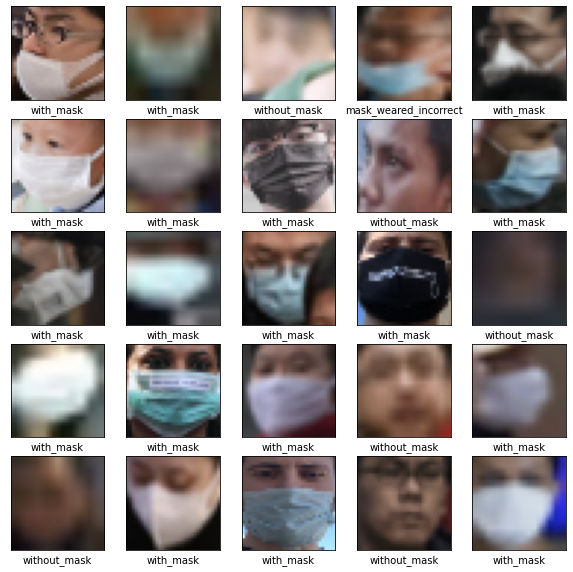

In [41]:
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i])
    plt.xlabel(classes[train_labels[i][0]])
plt.show()

In [42]:
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))

In [43]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_9 (Conv2D)           (None, 30, 30, 32)        896       
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 15, 15, 32)       0         
 2D)                                                             
                                                                 
 conv2d_10 (Conv2D)          (None, 13, 13, 64)        18496     
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 6, 6, 64)         0         
 2D)                                                             
                                                                 
 conv2d_11 (Conv2D)          (None, 4, 4, 64)          36928     
                                                                 
Total params: 56,320
Trainable params: 56,320
Non-trai

In [44]:
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(10))

In [45]:
print(np.array(train_images, dtype=object).shape)

(1018, 32, 32, 3)


In [46]:
print(train_labels.shape)

(1018, 1)


In [47]:
print(np.array(test_images, dtype=object).shape)

(3054, 32, 32, 3)


In [48]:
print(test_labels.shape)

(3054, 1)


In [49]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

history = model.fit(np.array(train_images), train_labels, epochs=10,
                    validation_data=(np.array(test_images), test_labels))

Epoch 1/10
32/32 [==============================] - 2s 39ms/step - loss: 0.7535 - accuracy: 0.7878 - val_loss: 0.4793 - val_accuracy: 0.7931
Epoch 2/10
32/32 [==============================] - 1s 33ms/step - loss: 0.3606 - accuracy: 0.8644 - val_loss: 0.2594 - val_accuracy: 0.9181
Epoch 3/10
32/32 [==============================] - 1s 35ms/step - loss: 0.2860 - accuracy: 0.9116 - val_loss: 0.2685 - val_accuracy: 0.9168
Epoch 4/10
32/32 [==============================] - 1s 36ms/step - loss: 0.2229 - accuracy: 0.9352 - val_loss: 0.2280 - val_accuracy: 0.9325
Epoch 5/10
32/32 [==============================] - 1s 33ms/step - loss: 0.2236 - accuracy: 0.9312 - val_loss: 0.2150 - val_accuracy: 0.9322
Epoch 6/10
32/32 [==============================] - 1s 35ms/step - loss: 0.2026 - accuracy: 0.9391 - val_loss: 0.2294 - val_accuracy: 0.9368
Epoch 7/10
32/32 [==============================] - 1s 36ms/step - loss: 0.2186 - accuracy: 0.9352 - val_loss: 0.2177 - val_accuracy: 0.9335
Epoch 8/10
32

96/96 - 1s - loss: 0.1893 - accuracy: 0.9407 - 582ms/epoch - 6ms/step


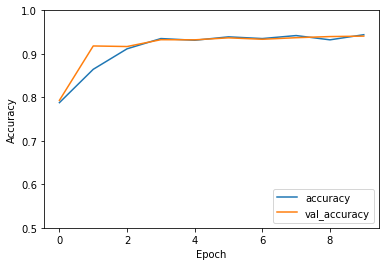

In [50]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

test_loss, test_acc = model.evaluate(np.array(test_images),  test_labels, verbose=2)

1/1 [==============================] - 0s 16ms/step


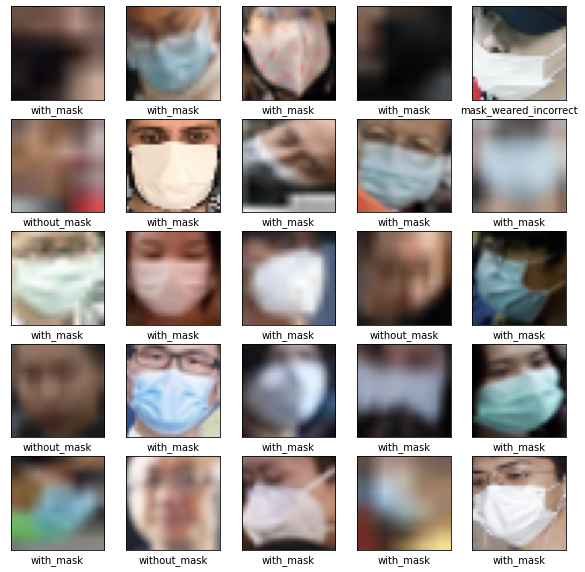

In [51]:
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(test_images[i])
    thing = test_images[i].reshape((1, 32, 32, 3))
    plt.xlabel(classes[np.argmax(model.predict(thing), axis=1)[0]])
plt.show()